# CALF interactive testing

In [2]:
import logging
import os
from pathlib import Path


import datacube
import fiona
import geopandas
import ipywidgets as widgets
import numpy as np
import rasterio
import rasterio.features
import rasterio.transform
import rasterio.windows
import rioxarray
import rioxarray.crs
import rioxarray.merge
import xarray as xr
from datacube.utils import geometry as dc_geometry
from IPython.display import display

from calf import calf

# this is a minor detail, toning down third-party loggers
logging.basicConfig(level=logging.DEBUG)
for logger_name in ("datacube", "fiona", "matplotlib", "pyproj", "rasterio"):
    logging.getLogger(logger_name).setLevel(logging.WARNING)


## Initial processing

In this section we create a new datacube client, then proceed to load the region of interest and crop mask files. These auxiliary files are intersected in order to give us a set of features to focus on during the analysis.

For didatic purposes we then focus on the first intersected feature - the real CALF algorithm processor (see below) is able to handle the analysis for all features.

In [10]:
dc = datacube.Datacube(
    app="test-calf",
    env="sandbox",
    config=os.getenv("DATACUBE_CONFIG_PATH")
)

roi_df = geopandas.read_file(Path("../test-data/auxiliary.gpkg"), layer="region-of-interest")
crop_df = geopandas.read_file(Path("../test-data/auxiliary.gpkg", layer="crop-mask"))

intersected_df = geopandas.overlay(
    roi_df, 
    crop_df.to_crs(epsg=roi_df.crs.to_epsg()),  # reprojecting on-the-fly 
    how="intersection", 
    keep_geom_type=True
)
intersected_df

test_series1 = intersected_df.iloc[0]

# lets select the series that uses parcel3
test_series2 = intersected_df.query("name_1 == 'municipality1' & name_2 == 'parcel3'").iloc[0]

base_query = {
    "time": ("2015-01-01", "2021-12-31"),
    "measurements": ["red", "nir", "spclass"],
    "output_crs": "EPSG:32635",
    "resolution": (-10, 10),
    "resampling": "cubic",
    "geopolygon": dc_geometry.Geometry(
        test_series2.geometry.__geo_interface__,
        dc_geometry.CRS(f"EPSG:{intersected_df.crs.to_epsg()}")
    ),
    "product": "test_spot7_gauteng_old_eo3",
}

ds = dc.load(**base_query)
ds

/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(
/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<xarray.Dataset>
Dimensions:      (time: 2, x: 24, y: 36)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) int16 947 860 1008 1070 1021 ... 959 951 975 981
    nir          (time, y, x) int16 2182 2221 2489 2332 ... 1752 1308 1219 1179
    spclass      (time, y, x) uint8 69 70 70 58 68 70 70 ... 58 43 21 20 20 20
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref

## Apply quality flags to mask out bad pixels

The `ds` variable now holds an `xarray.Dataset` with the ARd data that we want to work with. We move on by selecting only those pixels that have good quality

In [15]:
valid_ds = calf.apply_validity_mask(ds, "spclass")
valid_ds

<xarray.Dataset>
Dimensions:      (time: 2, x: 24, y: 36)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) float64 947.0 860.0 1.008e+03 ... 975.0 981.0
    nir          (time, y, x) float64 2.182e+03 2.221e+03 ... 1.179e+03
    spclass      (time, y, x) float64 69.0 70.0 70.0 58.0 ... 20.0 20.0 20.0
Attributes:
    crs:           EPSG:32635
    grid_mapping:  spatial_ref

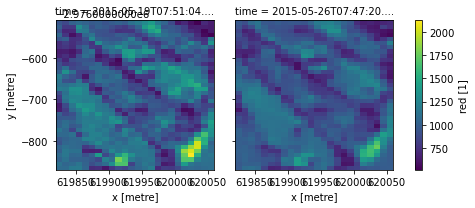

In [16]:
valid_ds.red.plot(col="time")

## Rasterize and apply crop mask

In order to perform the CALF analysis only on the relevant crop area, we convert the intersected feature (which is an intersection of the region of interest with the crop mask) into a 2d array and then use it as a mask. Values falling outside of the crop area are assigned a value of `np.nan`.

In [18]:
crop_mask_da = calf.rasterize_feature(valid_ds, test_series2)
crop_mask_da

<xarray.DataArray (y: 36, x: 24)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
...
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan,  1.,  1.,  1.,  1.,  1., nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan,  1.,  1.,  1.,  1., nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan,  1.,  1.,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan,  1.,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * y        (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x        (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05

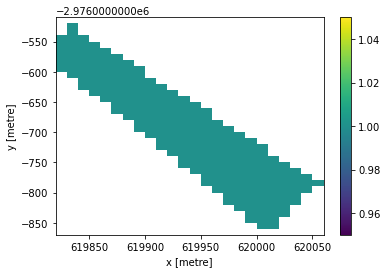

In [19]:
crop_mask_da.plot()

Applying the crop mask to our dataset

In [20]:
crop_ds = valid_ds * crop_mask_da
crop_ds

<xarray.Dataset>
Dimensions:      (time: 2, x: 24, y: 36)
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635
Data variables:
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    spclass      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

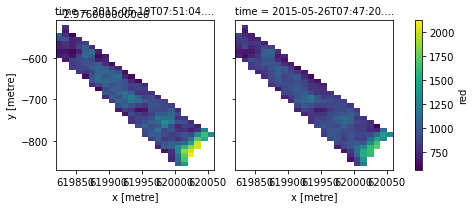

In [21]:
crop_ds.red.plot(col="time")

### Calculate individual and seasonal (i.e. aggregated) NDVI

In [22]:
ndvi_da = (crop_ds.nir - crop_ds.red) / (crop_ds.nir + crop_ds.red)
ndvi_da

<xarray.DataArray (time: 2, y: 36, x: 24)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 0.53141831,        nan, ...,        nan,
                nan,        nan],
        [       nan, 0.54463989,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 0.5249019 ,        nan, ...,        nan,
                nan,        nan],
        [       nan, 0.53170386,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2015-05-19T07:51:04.175035 2015-05-26T...
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635

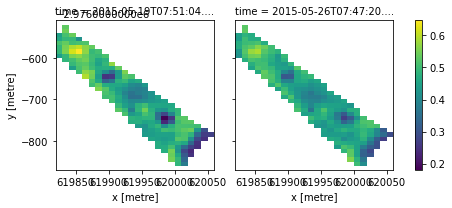

In [23]:
ndvi_da.plot(col="time")

Calculating the aggregated NDVI by using **Greenest Pixel Method** - which is just a matter of taking the pixelwise maximum value for the temporal series

In [24]:
aggregated_ndvi_da = ndvi_da.max(dim="time")
aggregated_ndvi_da

<xarray.DataArray (y: 36, x: 24)>
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.53141831,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.54463989,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [0.44621027, 0.50961538, 0.54095766,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
...
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.54115164, 0.46223146, 0.3246696 ,
        0.3049676 ,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.55798837, 0.48941122, 0.36661324,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.5004597 , 0.40746195,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]])
Coordinates:
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635

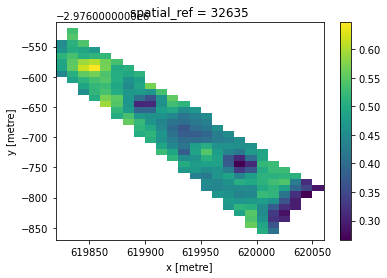

In [25]:
aggregated_ndvi_da.plot()

Now we discard those pixels that show an NDVI below the vegetation threshold - **FIXME: need to check if those are to be assigned some special value**

In [26]:
aggregated_vegetation_ndvi_da = aggregated_ndvi_da.where(aggregated_ndvi_da > 0.2)
aggregated_vegetation_ndvi_da

<xarray.DataArray (y: 36, x: 24)>
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.53141831,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [       nan, 0.54463989,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
       [0.44621027, 0.50961538, 0.54095766,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan],
...
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.54115164, 0.46223146, 0.3246696 ,
        0.3049676 ,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.55798837, 0.48941122, 0.36661324,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.5004597 , 0.40746195,
               nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]])
Coordinates:
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int32 32635

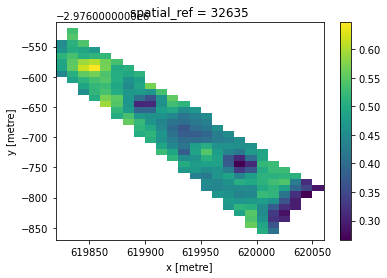

In [27]:
aggregated_vegetation_ndvi_da.plot()

## Compute CALF
Calculate the statistical measurements needed for the CALF calculation and then calculate the raw CALF and the reclassified one

In [36]:
mean = aggregated_vegetation_ndvi_da.mean()
std_dev = aggregated_vegetation_ndvi_da.std()
mean, std_dev

calf_da = (aggregated_vegetation_ndvi_da - mean) / std_dev
calf_da.rio.write_crs("epsg:32635", inplace=True)
calf_da

<xarray.DataArray (y: 36, x: 24)>
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  9.82458402e-01,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  1.17839058e+00,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
...
                    nan,             nan,             nan,
                    nan,             nan,  1.37620320e+00,
         3.59950286e-01, -1.45980753e+00,             nan,
                    nan,             nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
         5.23679056e-01, -8.54465543e-01,             nan,
                    nan,             nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan]])
Coordinates:
  * y            (y) float64 -2.977e+06 -2.977e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 6.198e+05 ... 6.2e+05 6.201e+05
    spatial_ref  int64 0

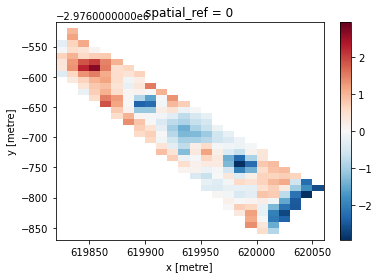

In [37]:
calf_da.plot()

In [38]:
reclassified_calf_da = xr.where(calf_da <= 1, 1, 0).astype(np.uint8) * crop_mask_da

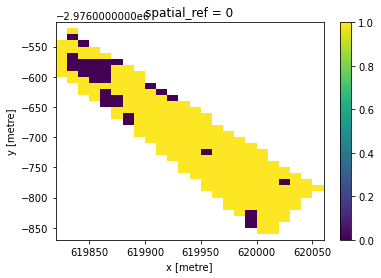

In [39]:
reclassified_calf_da.plot()

## Calculate statistics

In [40]:
counts, frequencies = np.unique(reclassified_calf_da, return_counts=True)

num_fallow_pixels = int(frequencies[counts == 0])
num_planted_pixels = int(frequencies[counts == 1])
total_pixels = int((~np.isnan(reclassified_calf_da)).sum())
print(f"fallow: {num_fallow_pixels}, planted: {num_planted_pixels}, total: {total_pixels}")

fallow: 32, planted: 207, total: 239


In [33]:
reclassified_calf_da.rio.to_raster("calf_parcel3.tif")

# Using the calf package

The calf package includes a `main()` function, which is the main way to execute it.

We start by doing some preparation:

- Create a datacube client
- Load the region of interest and crop mask

In [3]:
import logging
import os
from pathlib import Path


import datacube
import fiona
import geopandas
import ipywidgets as widgets
import numpy as np
import rasterio
import rasterio.features
import rasterio.transform
import rasterio.windows
import rioxarray
import rioxarray.crs
import rioxarray.merge
import xarray as xr
from datacube.utils import geometry as dc_geometry
from IPython.display import display

from calf import calf

# this is a minor detail, toning down third-party loggers
logging.basicConfig(level=logging.DEBUG)
for logger_name in ("datacube", "fiona", "matplotlib", "pyproj", "rasterio"):
    logging.getLogger(logger_name).setLevel(logging.WARNING)


In [4]:
dc = datacube.Datacube(
    app="test-calf",
    env="sandbox",
    config=os.getenv("DATACUBE_CONFIG_PATH")
)

roi_gdf = geopandas.read_file(Path("../test-data/auxiliary.gpkg"), layer="region-of-interest")
crop_gdf = geopandas.read_file(Path("../test-data/auxiliary.gpkg", layer="crop-mask"))

/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/datacube/drivers/postgres/_connections.py:81: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  EngineUrl(
/datadisk/miniconda3/envs/sansa-crop-arable-land-fraction/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Now we call `calf.main()` with a relevant set of input parameters. The result is a `xarray.Dataset` with multiple data arrays

In [5]:
calf_dataset, feature_calfs = calf.main(
    dc, 
    start_date="2015-01-01",
    end_date="2021-12-31",
    ard_product="test_spot7_gauteng_old_eo3",
    region_of_interest_gdf=roi_gdf,
    crop_mask_gdf=crop_gdf,
    vegetation_threshold=0.2,
    red_band="red",
    nir_band="nir",
    qflags_band="spclass",
    output_crs="EPSG:32635",
    output_resolution=20,
)

DEBUG:calf.calf:Finding input datasets...
DEBUG:calf.calf:Reprojecting geodataframe...
INFO:calf.calf:Processing area 1 of 6 (municipality1 - parcel1)...
DEBUG:calf.calf:Loading ARD data from datacube...
DEBUG:calf.calf:Applying cloud/shadow/water mask...
DEBUG:calf.calf:Rasterizing crop mask feature...
DEBUG:calf.calf:Applying crop mask...
DEBUG:calf.calf:Calculating daily NDVI...
DEBUG:calf.calf:Calculating aggregated NDVI...
DEBUG:calf.calf:Applying vegetation threshold to aggregated NDVI...
DEBUG:calf.calf:aggregated NDVI stats: mean: 0.4250122059499123 std_dev: 0.05540655888835156
DEBUG:calf.calf:Computing numeric CALF...
DEBUG:calf.calf:Computing reclassified CALF...
DEBUG:calf.calf:Counting number of fallow and planted pixels...
DEBUG:calf.calf:Gathering seasonal ndvi onto the main output dataset...
DEBUG:calf.calf:Gathering numeric CALF onto the main output dataset...
DEBUG:calf.calf:Gathering reclassified CALF onto the main output dataset...
INFO:calf.calf:Processing area 2 of

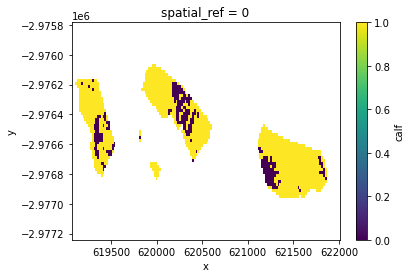

In [6]:
calf_dataset.calf.plot()

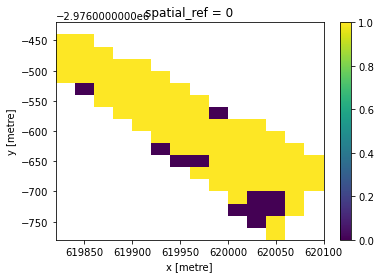

In [19]:
feature_calfs[0].reclassified_calf.plot()

In [41]:
feature_calfs[0].reclassified_calf.rio.bounds()

(619820.0, -2976780.0, 620100.0, -2976420.0)

In [42]:
window = rasterio.windows.from_bounds(*(feature_calfs[0].reclassified_calf.rio.bounds()), calf_dataset.calf.rio.transform())
window

Window(col_off=37.656411514290085, row_off=31.89386307640234, width=14.0, height=18.0)

In [43]:
start_row = int(window.row_off)
end_row = int(window.row_off + window.height)
start_row, end_row

(31, 49)

In [44]:
start_col = int(window.col_off)
end_col = int(window.col_off + window.width)
start_col, end_col

(37, 51)

In [46]:
calf_dataset.calf[start_row:end_row, start_col:end_col]

<xarray.DataArray 'calf' (y: 18, x: 14)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,
         1.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1., nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1., nan, nan,
        nan]])
Coordinates:
  * x            (x) float64 6.198e+05 6.198e+05 ... 6.201e+05 6.201e+05
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
    spatial_ref  int64 0

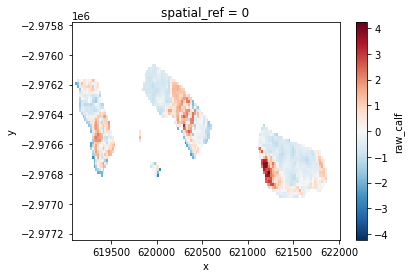

In [10]:
calf_dataset.raw_calf.plot()

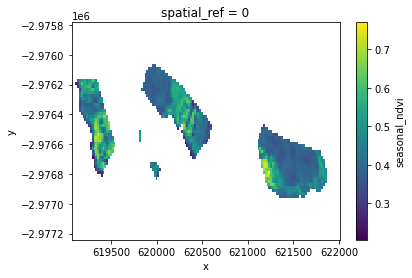

In [11]:
calf_dataset.seasonal_ndvi.plot()

In [12]:
calf.write_result_to_disk(calf_dataset, Path("test_all_features_20m.tif")) 

In [3]:
result = calf._compute_calf(dc, base_query, intersected_feature_series, "spclass", 32635, 0.2)

In [4]:
result.num_fallow_pixels, result.num_planted_pixels, result.total_pixels

(49, 298, 347)

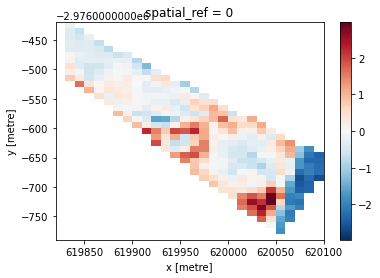

In [5]:
result.numeric_calf.plot()

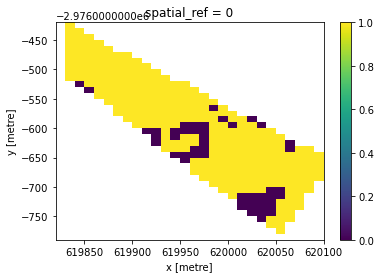

In [6]:
result.reclassified_calf.plot()

In [8]:
output_ds = calf._generate_output_dataset(roi_df, 10, numeric_calf_fill=np.nan, reclassified_calf_fill=np.nan)
output_ds

<xarray.Dataset>
Dimensions:      (x: 294, y: 146)
Coordinates:
  * x            (x) float64 6.191e+05 6.191e+05 6.191e+05 ... 6.22e+05 6.22e+05
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
    spatial_ref  int64 0
Data variables:
    raw_calf     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    calf         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [10]:
calf._overlay_arrays(output_ds[calf.CalfOutputName.RECLASSIFIED_CALF.value], result.reclassified_calf)

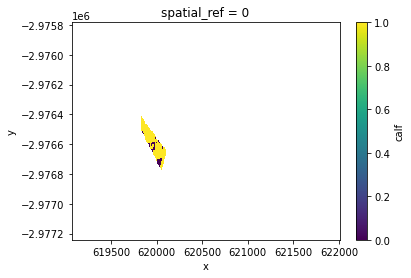

In [11]:
output_ds[calf.CalfOutputName.RECLASSIFIED_CALF.value].plot()

In [12]:
output_ds.rio.to_raster("test_final.tif")

In [8]:
roi_df.total_bounds

array([  619066.87176971, -2977235.43942781,   621999.41867034,
       -2975782.12273847])

In [104]:
output_resolution = 10
min_x, min_y, max_x, max_y = roi_df.total_bounds
width = int(np.ceil((max_x - min_x) / output_resolution))
height = int(np.ceil((max_y - min_y) / output_resolution))
height, width

(146, 294)

In [227]:
roi_transform = rasterio.Affine(output_resolution, 0.0, min_x, 0.0, -output_resolution, max_y)
roi_transform

Affine(10.0, 0.0, 619066.8717697142,
       0.0, -10.0, -2975782.1227384717)

In [332]:
roi_df.crs.to_epsg()

32635

In [295]:
roi_rasterized = rasterio.features.rasterize(
    ((geom.__geo_interface__, 255) for geom in roi_df.geometry), 
    out_shape=(height, width),
    transform=roi_transform,
    all_touched=True,
    fill=0
)

In [296]:
roi_rasterized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [114]:
profile = {
    "driver": "GTiff",
    "dtype": rasterio.uint8,
    "count": 1,
    "width": width,
    "height": height,
    "transform": roi_transform,
    "crs": "EPSG:32635"
}
with rasterio.open("test_rasterized_roi.tif", "w", **profile) as dst:
    dst.write(roi_rasterized, indexes=1)

In [297]:
row_coords = []
col_coords = []
for row in range(height):
#     row_coords.append((roi_transform * (row * output_resolution, 0))[0])
    row_coords.append(rasterio.transform.xy(roi_transform, row, 0)[1])

for col in range(width):
#     col_coords.append((roi_transform * (0, col * output_resolution))[1])
    col_coords.append(rasterio.transform.xy(roi_transform, 0, col)[0])

In [298]:
len(row_coords), height, len(col_coords), width

(146, 146, 294, 294)

In [299]:
roi_rasterized_da = xr.DataArray(
    roi_rasterized, 
    dims=("y", "x"), 
    coords={
        "x": col_coords, 
        "y": row_coords, 
        # "spatial_ref": result.reclassified_calf.coords["spatial_ref"]
    }
)
roi_rasterized_da.rio.write_crs("epsg:32635", inplace=True)
# roi_rasterized_ds = xr.Dataset({"roi_rasterized": roi_rasterized_da})
# roi_rasterized_ds.rio.write_crs("epsg:32635", inplace=True)

<xarray.DataArray (y: 146, x: 294)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x            (x) float64 6.191e+05 6.191e+05 6.191e+05 ... 6.22e+05 6.22e+05
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
    spatial_ref  int64 0

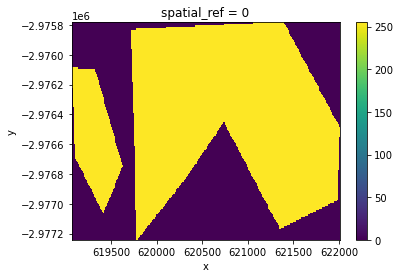

In [300]:
roi_rasterized_da.plot()

In [301]:
result.reclassified_calf.rio.write_crs("epsg:32635", inplace=True)

<xarray.DataArray (y: 37, x: 28)>
array([[nan,  1., nan, ..., nan, nan, nan],
       [nan,  1.,  1., ..., nan, nan, nan],
       [nan,  1.,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
  * x            (x) float64 6.198e+05 6.198e+05 ... 6.201e+05 6.201e+05
    spatial_ref  int64 0

In [302]:
reclassified_calf = result.reclassified_calf.astype(np.uint8)

In [320]:
[int(i) for i in reclassified_calf_da.rio.bounds()]

[619820, -2976790, 620100, -2976420]

In [322]:
calf_window = rasterio.windows.from_bounds(*reclassified_calf.rio.bounds(), transform=roi_rasterized_da.rio.transform())
calf_window

Window(col_off=75.31282302858017, row_off=63.78772615280468, width=28.0, height=37.0)

In [326]:
reclassified_calf_da.shape

(37, 28)

In [328]:
roi_rasterized_da[int(calf_window.row_off):int(calf_window.row_off + calf_window.height), int(calf_window.col_off):int(calf_window.col_off + calf_window.width)] = reclassified_calf_da.data

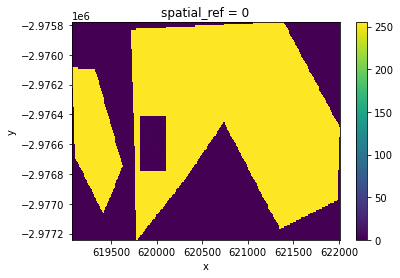

In [330]:
roi_rasterized_da.plot()

In [291]:
merged = rioxarray.merge.merge_arrays([roi_rasterized_da, reclassified_calf])

In [294]:
merged

<xarray.DataArray (y: 146, x: 294)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x            (x) float64 6.191e+05 6.191e+05 6.191e+05 ... 6.22e+05 6.22e+05
  * y            (y) float64 -2.976e+06 -2.976e+06 ... -2.977e+06 -2.977e+06
    spatial_ref  int64 0

In [195]:
ds = rioxarray.open_rasterio("../test-data/S7-E28S27-20150519-075104-P-SEN-SPOT7_20200221_102547146wfy9g4t3vb_1_ORTHO_PSH_cropped.pix")

In [199]:
ds.rio.transform()

Affine(1.5, 0.0, 618420.0,
       0.0, -1.5, -2975700.0)